#Custom Loss Fn 

##Preparing the environment


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Custom loss function

Objective: To train a regression model, but our training set is a bit noisy. 

Initial efforts to alleviate persisiting problems:

Started by trying to clean up the dataset by removing or fixing the outliers,
but that turns out to be insufficient; the dataset is still noisy. 

Loss Function In Question:

The mean squared error might penalize large errors too much and
cause the model to be imprecise. 

The mean absolute error would not penalize outliers
as much, but training might take a while to converge, and the trained model
might not be very precise. 

Using the Huber loss instead of the good old MSE. 

The Huber loss is not currently
part of the official Keras API, but it is available in tf.keras. 

Implementing it: 

Created a function that takes the labels and predictions as arguments, and use
TensorFlow operations to compute every instance’s loss.

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [4]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

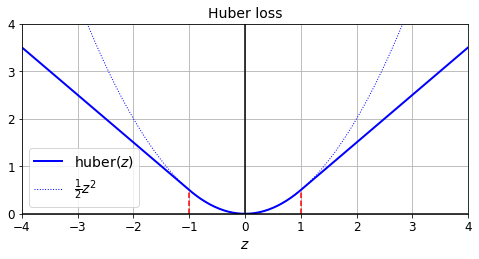

In [5]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [6]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [7]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

With the current implementation, any error between –1 and 1 is considered “small.”

In [8]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 1.0443 - mae: 1.4660 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2379 - mae: 0.5407 - val_loss: 0.2382 - val_mae: 0.5281


## Saving/Loading Models with Custom Objects

In [ ]:
model.save("my_model_with_a_custom_loss.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 970us/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 0s 769us/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2318 - mae: 0.4979 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 0s 749us/step - loss: 0.2309 - mae: 0.4960 - val_loss: 0.2372 - val_mae: 0.4879


In [ ]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 0s 763us/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

The constructor accepts **kwargs and passes them to the parent constructor,
which handles standard hyperparameters: 
  the name of the loss and the reduction algorithm to use to aggregate the individual instance losses. 
  
By default, it is
"sum_over_batch_size", which means that the loss will be the sum of the
instance losses, weighted by the sample weights, if any, and divided by the batch
size (not by the sum of weights, so this is not the weighted mean).

 Other possible values are "sum" and "none".


• The call() method takes the labels and predictions, computes all the instance
losses, and returns them.


• The get_config() method returns a dictionary mapping each hyperparameter
name to its value. It first calls the parent class’s get_config() method, then adds
the new hyperparameters to this dictionary (note that the convenient {**x} syntax
was added in Python 3.5).


In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.3123 - mae: 1.3345 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 0s 760us/step - loss: 0.2659 - mae: 0.5270 - val_loss: 0.2660 - val_mae: 0.5089


In [ ]:
model.save("my_model_with_a_custom_loss_class.h5")

When you save the model, the threshold will be saved along with it; and when you
load the model, you just need to map the class name to the class itself:

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

## Other Custom Functions

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

If a function has hyperparameters that need to be saved along with the model, then
you will want to subclass the appropriate class, such as keras.regularizers.Regular
izer, keras.constraints.Constraint, keras.initializers.Initializer, or
keras.layers.Layer (for any layer, including activation functions).

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 757us/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 757us/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 966us/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 0s 757us/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [ ]:
model.loss.threshold

2.0

## Custom Metrics

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 572us/step - loss: 3.5903 - huber_fn: 1.5558
Epoch 2/2
363/363 [==============================] - 0s 552us/step - loss: 0.8054 - huber_fn: 0.3095


**Note**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 598us/step - loss: 0.1245 - huber_fn: 0.2515
Epoch 2/2
363/363 [==============================] - 0s 558us/step - loss: 0.1216 - huber_fn: 0.2473


In [ ]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11749906837940216, 0.11906625573138947)

### Streaming metrics

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [ ]:
precision.reset_states()

Creating a streaming metric:

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [ ]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [ ]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [ ]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 592us/step - loss: 1.5182 - huber_metric: 1.5182
Epoch 2/2
363/363 [==============================] - 0s 538us/step - loss: 0.2909 - huber_metric: 0.2909


In [ ]:
model.save("my_model_with_a_custom_metric.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 545us/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 0s 524us/step - loss: 0.2278 - huber_metric: 0.2278


**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [ ]:
model.metrics[-1].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [ ]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 627us/step - loss: 0.7800 - HuberMetric: 1.5672
Epoch 2/2
363/363 [==============================] - 0s 607us/step - loss: 0.1462 - HuberMetric: 0.2939


In [ ]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44554394483566284, 0.44554404180100277)

In [ ]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 578us/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 0s 559us/step - loss: 0.2279 - HuberMetric: 0.2279


2.0

## Custom Layers

You may occasionally want to build an architecture that contains an exotic layer for
which TensorFlow does not provide a default implementation. In this case, you will
need to create a custom layer. Or you may simply want to build a very repetitive
architecture, containing identical blocks of layers repeated many times, and it would
be convenient to treat each block of layers as a single layer. For example, if the model
is a sequence of layers A, B, C, A, B, C, A, B, C, then you might want to define a custom
layer D containing layers A, B, C, so your model would then simply be D, D, D.
Let’s see how to build custom layers

Some layers have no weights, such as keras.layers.Flatten or keras.lay
ers.ReLU. If you want to create a custom layer without any weights, the simplest
option is to write a function and wrap it in a keras.layers.Lambda laye

In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [ ]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 0s 828us/step - loss: 2.1275 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 0s 645us/step - loss: 0.4750 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 0s 656us/step - loss: 0.4230 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 0s 657us/step - loss: 0.3905 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 420us/step - loss: 0.3586


0.3586340546607971

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 898us/step - loss: 4.1268 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 419us/step - loss: 0.5474


0.5473727583885193

In [ ]:
model.save("my_model_with_a_custom_layer.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [ ]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

Let's create a layer with a different behavior during training and testing:

In [ ]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 899us/step - loss: 0.5496 - val_loss: 0.5329
Epoch 2/2
162/162 [==============================] - 0s 420us/step - loss: 0.3990


0.3990039527416229

## Custom Models

In [ ]:
X_new_scaled = X_test_scaled

Note that this model does not make much sense; it’s just an example to
illustrate the fact that you can easily build any kind of model you want, even one that
contains loops and skip connections.

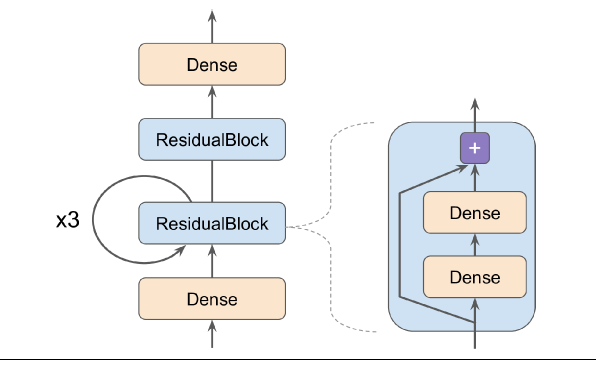

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 837us/step - loss: 22.7478
Epoch 2/5
363/363 [==============================] - 0s 739us/step - loss: 1.2735
Epoch 3/5
363/363 [==============================] - 0s 737us/step - loss: 0.9792
Epoch 4/5
363/363 [==============================] - 0s 740us/step - loss: 0.5905
Epoch 5/5
162/162 [==============================] - 0s 526us/step - loss: 0.6513


In [ ]:
model.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


In [ ]:
model = keras.models.load_model("my_custom_model.ckpt")

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 851us/step - loss: 0.9476
Epoch 2/5
363/363 [==============================] - 0s 736us/step - loss: 0.6998
Epoch 3/5
363/363 [==============================] - 0s 737us/step - loss: 0.4668
Epoch 4/5
363/363 [==============================] - 0s 758us/step - loss: 0.4818
Epoch 5/5
363/363 [==============================] - 0s 756us/step - loss: 0.4591


We could have defined the model using the sequential API instead:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 709us/step - loss: 1.5508
Epoch 2/5
363/363 [==============================] - 0s 645us/step - loss: 0.5562
Epoch 3/5
363/363 [==============================] - 0s 625us/step - loss: 0.6406
Epoch 4/5
363/363 [==============================] - 0s 636us/step - loss: 0.3759
Epoch 5/5
162/162 [==============================] - 0s 463us/step - loss: 0.4852


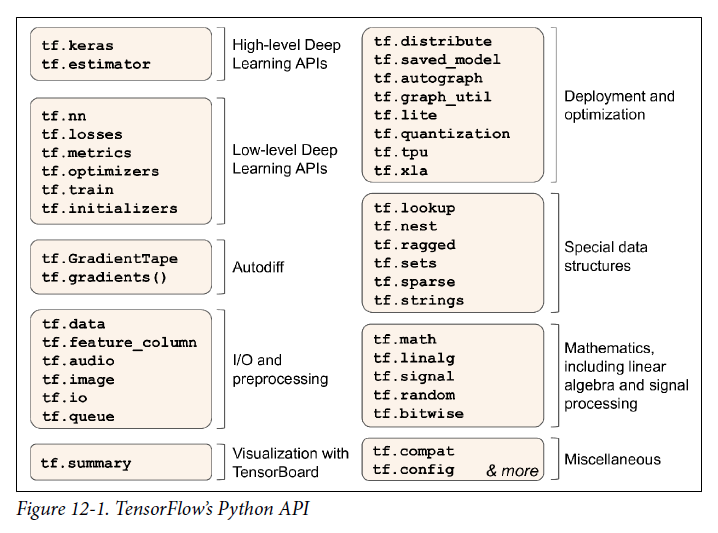